[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drdave-teaching/OPIM5509Files/blob/main/OPIM5509_Module4_Files/Multivariate_Occupancy_RNN.ipynb)

# Multivariate Ozone Example (RNN)
----------------------------
**Dr. Dave Wanik - University of Connecticut**

Let's see if we can predict if it's an ozone day as a function of environmental data.

Link: http://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

Same flow as before, just need to prep our data differently. For now, we ignore the time dimension but we could resample to a regular resolution.

Wow - also a nice example: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [ ]:
# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RNN-specific modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping

## Read in data
Check for missing values, make some plots.

In [ ]:
# Dataset initially sourced from LuisM78’s GitHub repository:
# url = 'https://raw.githubusercontent.com/LuisM78/Occupancy-detection-data/master/datatest.txt'
# Link to the data file on Github
url = "https://raw.githubusercontent.com/drdave-teaching/OPIM5509Files/refs/heads/main/OPIM5509_Module4_Files/datatest.txt"

# read the data
df = pd.read_csv(url)
print(df.info())
df.head(n=15) # nice complete data! this will allow us to check our work later

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 140 to 2804
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           2665 non-null   object 
 1   Temperature    2665 non-null   float64
 2   Humidity       2665 non-null   float64
 3   Light          2665 non-null   float64
 4   CO2            2665 non-null   float64
 5   HumidityRatio  2665 non-null   float64
 6   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 166.6+ KB
None


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1
145,2015-02-02 14:23:59,23.7600,26.260,568.666667,790.000000,0.004779,1
146,2015-02-02 14:25:00,23.7300,26.290,536.333333,798.000000,0.004776,1
147,2015-02-02 14:25:59,23.7540,26.290,509.000000,797.000000,0.004783,1
148,2015-02-02 14:26:59,23.7540,26.350,476.000000,803.200000,0.004794,1
149,2015-02-02 14:28:00,23.7360,26.390,510.000000,809.000000,0.004796,1


In [ ]:
# count of occupancy
df['Occupancy'].value_counts() # not perfectly balanced, but that's OK

0    1693
1     972
Name: Occupancy, dtype: int64

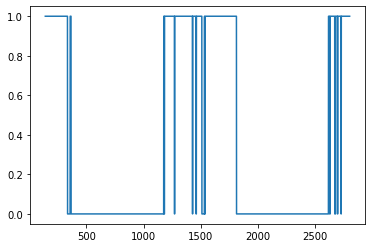

In [ ]:
# visualize the data
df['Occupancy'].plot()
plt.show()

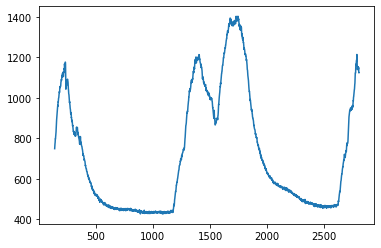

In [ ]:
# visualize the data
df['CO2'].plot()
plt.show()

In [ ]:
# drop the date column
df.drop(['date'], inplace=True, axis=1)
print(df.shape)
df.head()

(2665, 6)


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,23.7000,26.272,585.200000,749.200000,0.004764,1
141,23.7180,26.290,578.400000,760.400000,0.004773,1
142,23.7300,26.230,572.666667,769.666667,0.004765,1
143,23.7225,26.125,493.750000,774.750000,0.004744,1
144,23.7540,26.200,488.600000,779.000000,0.004767,1


In [ ]:
# prep data for modeling (multivariate)
# link: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in np.arange(len(sequences)): # be careful of this line!
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
# we could split our data first, normalize it, then create sequences

In [ ]:
# all we need to do is decide on is n_steps (what our lookback period is)
# since we have a bunch of data, why not n_steps=10? then try 30 later on.
n_steps = 10
raw_seq = np.array(df) #make sure your data is stored as a numpy array!
# let's ignore the date column and just use the temperature data
X, y = split_sequences(raw_seq, n_steps=10)

In [ ]:
# take a peak at what it did
print(X.shape)
print(y.shape)

# scroll up and make sure you understand this!
# y is a function of X (the previous n_steps observations!)

(2656, 10, 5)
(2656,)


In [ ]:
# check the first few values
X[0]

array([[2.37000000e+01, 2.62720000e+01, 5.85200000e+02, 7.49200000e+02,
        4.76416302e-03],
       [2.37180000e+01, 2.62900000e+01, 5.78400000e+02, 7.60400000e+02,
        4.77266099e-03],
       [2.37300000e+01, 2.62300000e+01, 5.72666667e+02, 7.69666667e+02,
        4.76515255e-03],
       [2.37225000e+01, 2.61250000e+01, 4.93750000e+02, 7.74750000e+02,
        4.74377336e-03],
       [2.37540000e+01, 2.62000000e+01, 4.88600000e+02, 7.79000000e+02,
        4.76659400e-03],
       [2.37600000e+01, 2.62600000e+01, 5.68666667e+02, 7.90000000e+02,
        4.77933243e-03],
       [2.37300000e+01, 2.62900000e+01, 5.36333333e+02, 7.98000000e+02,
        4.77613633e-03],
       [2.37540000e+01, 2.62900000e+01, 5.09000000e+02, 7.97000000e+02,
        4.78309371e-03],
       [2.37540000e+01, 2.63500000e+01, 4.76000000e+02, 8.03200000e+02,
        4.79409400e-03],
       [2.37360000e+01, 2.63900000e+01, 5.10000000e+02, 8.09000000e+02,
        4.79618871e-03]])

In [ ]:
# check Y
y[0]

1.0

In [ ]:
# split the data into train and test partitions
# we will use 50% of the data for train, and 50% for validation
train_pct_index = int(0.5 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# pretty slick way of splitting your data using slicing!
# notice how we didn't do any shuffling (we don't want temporal leakage! keeps time series intact)

In [ ]:
# check the shape to be sure
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

# verify that this all adds up!
# 2635 samples with 30 lookback and 6 columns

(2656, 10, 5) (1328, 10, 5) (1328, 10, 5)
(2656,) (1328,) (1328,)


# RNN one layer model

In [ ]:
# define
n_steps = X_train.shape[1]
n_features = X_train.shape[2]

print(n_steps, n_features)

10 5


In [ ]:
# now let's build a model
# NEED TO UPDATE FOR CLASSIFICATION

# define
n_steps = X_train.shape[1]
n_features = X_train.shape[2]

# define model
model = Sequential()
model.add(SimpleRNN(30, input_shape=(n_steps,n_features), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])


es = EarlyStopping(monitor='val_acc', mode='max',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 30)                1080      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,111
Trainable params: 1,111
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
213/213 [==============================] - 2s 4ms/step - loss: 26.3075 - acc: 0.8230 - val_loss: 6.4034 - val_acc: 0.3910
Epoch 2/500
213/213 [==============================] - 1s 3ms/step - loss: 1.1968 - acc: 0.9473 - val_loss: 3.8604 - val_acc: 0.4098
Epoch 3/500
213/213 [==============================] - 1s 3ms/step - loss: 0.9819 - acc: 0.9435 - val_loss: 1.0608 - val_acc: 0.9774
Epoch 4/500
213/213 [===========================

In [ ]:
# make a prediction
pred = model.predict(X_train)# the pred
print(pred) # round them!

pred = np.round(pred,0)
pred # run all if you get an error...

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_train, pred)) # looks pretty good!
print(classification_report(y_train, pred))

[[808  36]
 [  2 482]]
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       844
         1.0       0.93      1.00      0.96       484

    accuracy                           0.97      1328
   macro avg       0.96      0.98      0.97      1328
weighted avg       0.97      0.97      0.97      1328



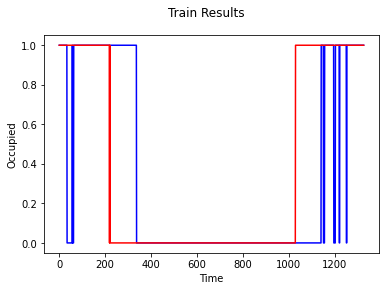

In [ ]:
# show timeseries plot on the train and validation data
plt.plot(np.arange(X_train.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_train.shape[0]), pred, color='red') # predicted data
plt.suptitle('Train Results')
plt.xlabel('Time')
plt.ylabel('Occupied')
plt.show()

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[820  29]
 [  8 471]]
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       849
         1.0       0.94      0.98      0.96       479

    accuracy                           0.97      1328
   macro avg       0.97      0.97      0.97      1328
weighted avg       0.97      0.97      0.97      1328



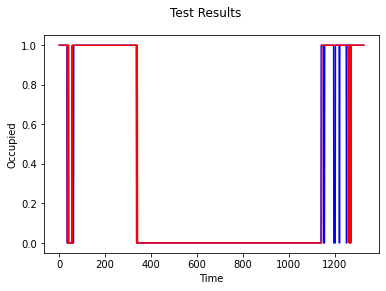

In [ ]:
# put it all together for other models

# make a prediction
pred = model.predict(X_test)# the pred
print(pred) # round them!

pred = np.round(pred,0)
print(pred) # run all if you get an error...

# confusion matrix - put this at the top!
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, pred)) # looks pretty good!
print(classification_report(y_test, pred))

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Occupied')
plt.show()

# LSTM one layer model
Literally, just grab the code above and change SimpleRNN to LSTM and boom! you have a more sophisticated model.

In [ ]:
# now let's build a model

# since this is a univariate problem, n_features will be 1 (we also defined this before)

# define model
model = Sequential()
model.add(LSTM(30, input_shape=(n_steps,n_features), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])
model.summary()

es = EarlyStopping(monitor='val_acc',
                   mode='max',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30)                4320      
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 4,351
Trainable params: 4,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
213/213 [==============================] - 2s 6ms/step - loss: 3.8597 - acc: 0.5640 - val_loss: 0.4174 - val_acc: 0.9361
Epoch 2/500
213/213 [==============================] - 1s 4ms/step - loss: 0.1232 - acc: 0.9661 - val_loss: 0.7720 - val_acc: 0.6767
Epoch 3/500
213/213 [==============================] - 1s 4ms/step - loss: 0.1096 - acc: 0.9633 - val_loss: 0.4848 - val_acc: 0.7970
Epoch 4/500
213/213 [============================

[[0.9999033 ]
 [0.9995415 ]
 [0.88509786]
 ...
 [1.        ]
 [1.        ]
 [0.99999964]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[814  35]
 [  4 475]]
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       849
         1.0       0.93      0.99      0.96       479

    accuracy                           0.97      1328
   macro avg       0.96      0.98      0.97      1328
weighted avg       0.97      0.97      0.97      1328



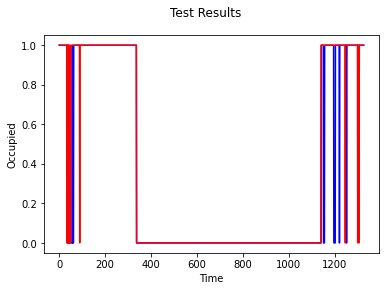

In [ ]:
# put it all together for other models

# make a prediction
pred = model.predict(X_test)# the pred
print(pred) # round them!

pred = np.round(pred,0)
print(pred) # run all if you get an error...

# confusion matrix - put this at the top!
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, pred)) # looks pretty good!
print(classification_report(y_test, pred))

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Occupied')
plt.show()

# RNN two layer model
Don't forget to set return_sequences=True!

In [ ]:
# now let's build a model

# since this is a univariate problem, n_features will be 1 (we also defined this before)

# define model
model = Sequential()
model.add(SimpleRNN(30, input_shape=(n_steps,n_features), return_sequences=True, activation='relu'))
                                    # note that the output when
                                    # return_sequences=True makes the output [n_steps, features]
                                    # where rows = n_steps (10!) and features = hidden size (30!)
model.add(SimpleRNN(30)) # output is a simple vector [1,30] that goes into a dense layer
                          # NO RETURN_SEQUENCES!!!
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])
model.summary()

es = EarlyStopping(monitor='val_acc', mode='max',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 10, 30)            1080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 30)                1830      
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 2,941
Trainable params: 2,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
213/213 [==============================] - 2s 6ms/step - loss: 0.4121 - acc: 0.8173 - val_loss: 0.7675 - val_acc: 0.0226
Epoch 2/500
213/213 [==============================] - 1s 5ms/step - loss: 0.2927 - acc: 0.7891 - val_loss: 0.6920 - val_acc: 0.9774
Epoch 3/500
213/213 [=============================

[[0.5006269]
 [0.5006269]
 [0.5006269]
 ...
 [0.5006269]
 [0.5006269]
 [0.5006269]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[827  22]
 [156 323]]
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90       849
         1.0       0.94      0.67      0.78       479

    accuracy                           0.87      1328
   macro avg       0.89      0.82      0.84      1328
weighted avg       0.88      0.87      0.86      1328



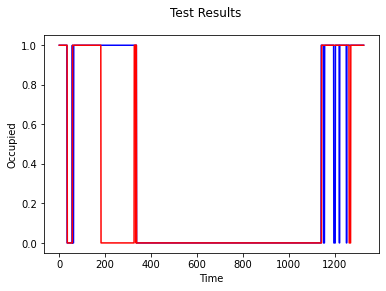

In [ ]:
# put it all together for other models

# make a prediction
pred = model.predict(X_test)# the pred
print(pred) # round them!

pred = np.round(pred,0)
print(pred) # run all if you get an error...

# confusion matrix - put this at the top!
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, pred)) # looks pretty good!
print(classification_report(y_test, pred))

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Occupied')
plt.show()

# Baseline Model
What if you just use yesterday's value as the prediction?!

In [ ]:
# baseline model - prediction is just the previous time step (a tough one to beat!)
df['Baseline'] = df['Occupancy'].shift(1)
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Baseline
140,23.7000,26.272,585.200000,749.200000,0.004764,1,NaN
141,23.7180,26.290,578.400000,760.400000,0.004773,1,1.0
142,23.7300,26.230,572.666667,769.666667,0.004765,1,1.0
143,23.7225,26.125,493.750000,774.750000,0.004744,1,1.0
144,23.7540,26.200,488.600000,779.000000,0.004767,1,1.0


In [ ]:
y_test_baseline = df['Baseline']
# just extract rows corresponding to y_test
y_test_baseline = y_test_baseline.tail(y_test.shape[0])
# verify shape
print(y_test.shape)
print(y_test_baseline.shape) # good!

(1328,)
(1328,)


[[842   7]
 [  7 472]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       849
         1.0       0.99      0.99      0.99       479

    accuracy                           0.99      1328
   macro avg       0.99      0.99      0.99      1328
weighted avg       0.99      0.99      0.99      1328



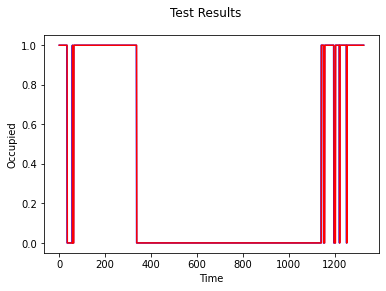

In [ ]:
# see how it does!
pred = y_test_baseline # the pred

# confusion matrix - put this at the top!
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, pred)) # looks pretty good!
print(classification_report(y_test, pred))

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Occupied')
plt.show()

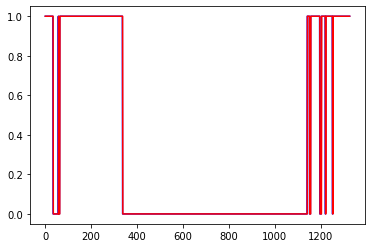

In [ ]:
# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.show()
# looks good, BUT it's not a smart model! all the data is just shifted.

In [ ]:
# be careful of the baseline model
# and make sure you choose an appropriate measure
# for the problem you are trying to solve...